<a href="https://colab.research.google.com/github/Trushali29/Artificial-Intelligence-In-Agritculture/blob/main/LeafClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
#root_path = 'gdrive/My Drive/PlantVillage_Dataset/'  #change dir to your project folder

Mounted at /content/gdrive


In [ ]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
#from keras.applications.Vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from glob import glob

In [ ]:
# unzip the dataset
#!unzip "/content/drive/MyDrive/PlantVillage_Dataset.zip" -d "/content/drive/MyDrive/"

In [ ]:
#image input size 
IMAGE_SIZE = [224,224]
#providing paths to train and test dataset
train_path ='/content/gdrive/MyDrive/PlantVillage_Dataset/train' 
valid_path = '/content/gdrive/MyDrive/PlantVillage_Dataset/validate'

In [ ]:
#download inception weights
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
# don't train existing weights
for layer in inception.layers:
  layer.trainable = False 

In [ ]:
# useful for getting number of output classes
folders = glob('/content/gdrive/MyDrive/PlantVillage_Dataset/train/*')

In [ ]:
x = Flatten()(inception.output)
x = Dense(500, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=inception.input, outputs=prediction)

In [ ]:
# summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
# tell the model what cost function and optimization method to use
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [ ]:
# use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator( rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
validate_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
training_set = train_datagen.flow_from_directory('/content/gdrive/MyDrive/PlantVillage_Dataset/train',
                                                 target_size = (224,224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 9610 images belonging to 10 classes.


In [ ]:
validate_set = validate_datagen.flow_from_directory('/content/gdrive/MyDrive/PlantVillage_Dataset/validate',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 1602 images belonging to 10 classes.


In [15]:
# fit the model
r = model.fit(
  training_set,
  validation_data=validate_set,
  epochs=15,
  steps_per_epoch=len(training_set),
  validation_steps=len(validate_set)
)

Epoch 1/15
301/301 [==============================] - 2891s 10s/step - loss: 2.6202 - accuracy: 0.8232 - val_loss: 0.4330 - val_accuracy: 0.8876
Epoch 2/15
301/301 [==============================] - 1315s 4s/step - loss: 0.2648 - accuracy: 0.9190 - val_loss: 0.2684 - val_accuracy: 0.9213
Epoch 3/15
301/301 [==============================] - 1291s 4s/step - loss: 0.1859 - accuracy: 0.9422 - val_loss: 0.1964 - val_accuracy: 0.9426
Epoch 4/15
301/301 [==============================] - 1287s 4s/step - loss: 0.1570 - accuracy: 0.9511 - val_loss: 0.3862 - val_accuracy: 0.8976
Epoch 5/15
301/301 [==============================] - 1297s 4s/step - loss: 0.1540 - accuracy: 0.9528 - val_loss: 0.1699 - val_accuracy: 0.9507
Epoch 6/15
301/301 [==============================] - 1294s 4s/step - loss: 0.1013 - accuracy: 0.9669 - val_loss: 0.1780 - val_accuracy: 0.9569
Epoch 7/15
301/301 [==============================] - 1296s 4s/step - loss: 0.1119 - accuracy: 0.9636 - val_loss: 0.2229 - val_accuracy

In [16]:
# save it as a h5 file
from tensorflow.keras.models import load_model
model.save('model_inception.h5')

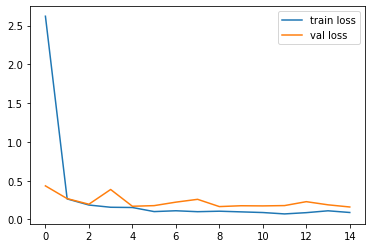

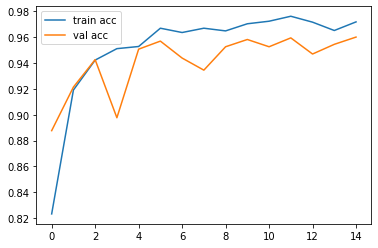

<Figure size 432x288 with 0 Axes>

In [17]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

#plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [18]:
from tensorflow.keras.models import load_model
MODEL_PATH = 'model_inception.h5'

#load your trained model
model = load_model(MODEL_PATH)

In [19]:
import matplotlib.image as mpimg

def model_predict(img_path, model):
    print(img_path)
    img = image.load_img(img_path, target_size=(224, 224))

    # Preprocessing the image
    x = image.img_to_array(img)
    ## Scaling
    x=x/255
    x = np.expand_dims(x, axis=0)

    preds = model.predict(x)
    preds=np.argmax(preds, axis=1)
    if preds==0:
        preds="The leaf is a diseased Apple leaf."
    elif preds==1:
        preds="The leaf is a healthy Apple leaf."
    elif preds==2:
        preds="The leaf is a diseased Cherry leaf."
    elif preds==3:
        preds="The leaf is a healthy Cherry leaf."
    elif preds==4:
        preds="The leaf is a diseased Corn leaf."
    elif preds==5:
        preds="The leaf is a healthy Corn leaf."
    elif preds==6:
        preds="The leaf is a diseased Pepper leaf."
    elif preds==7:
        preds="The leaf is a healthy Pepper leaf."
    elif preds==8:
        preds="The leaf is a diseased Tomato leaf."
    else:
        preds="The leaf is a healthy Tomato leaf."
    
    return preds

In [20]:
def outcome_and_image(img_path,model):
  result = model_predict(img_path,model)
  img = mpimg.imread(img_path)
  print('')
  return plt.imshow(img),result

/content/drive/MyDrive/PlantVillage_Dataset/test/Cherry_diseased_leaf/0df55dba-60e0-44e6-b64a-1f4d9a1377fd___FREC_Pwd.M 0527.JPG

Result: The leaf is a diseased Cherry leaf.


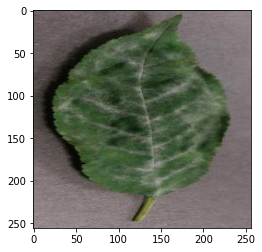

In [25]:
# diseased cherry leaf
img_path='/content/drive/MyDrive/PlantVillage_Dataset/test/Cherry_diseased_leaf/0df55dba-60e0-44e6-b64a-1f4d9a1377fd___FREC_Pwd.M 0527.JPG'
im, output = outcome_and_image(img_path, model)
im
print(f'Result: {output}')

/content/drive/MyDrive/PlantVillage_Dataset/test/Cherry_healthy_leaf/0e74a030-4b86-4c3f-8944-31e68d1911ba___JR_HL 4016.JPG

Result: The leaf is a healthy Cherry leaf.


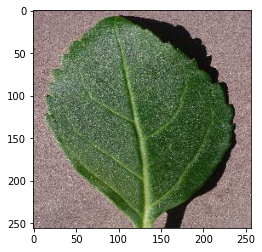

In [26]:
# healthy cherry leaf
img_path='/content/drive/MyDrive/PlantVillage_Dataset/test/Cherry_healthy_leaf/0e74a030-4b86-4c3f-8944-31e68d1911ba___JR_HL 4016.JPG'
im, output = outcome_and_image(img_path, model)
im
print(f'Result: {output}')

/content/drive/MyDrive/PlantVillage_Dataset/test/Pepper_diseased_leaf/12342367-f62b-40d0-897b-77bd1edbd3d1___JR_B.Spot 3199.JPG

Result: The leaf is a diseased Pepper leaf.


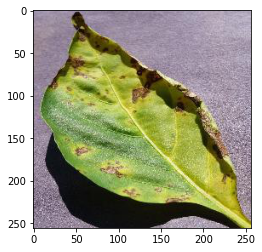

In [28]:
# diseased pepper leaf 
img_path = '/content/drive/MyDrive/PlantVillage_Dataset/test/Pepper_diseased_leaf/12342367-f62b-40d0-897b-77bd1edbd3d1___JR_B.Spot 3199.JPG'
im, output = outcome_and_image(img_path, model)
im    
print(f'Result: {output}')

/content/drive/MyDrive/PlantVillage_Dataset/test/Pepper_healthy_leaf/0dd09705-5593-4d01-9a9b-c1d5857daf92___JR_HL 8212.JPG

Result: The leaf is a healthy Pepper leaf.


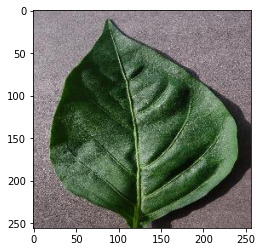

In [29]:
# healthy pepper leaf 
img_path = '/content/drive/MyDrive/PlantVillage_Dataset/test/Pepper_healthy_leaf/0dd09705-5593-4d01-9a9b-c1d5857daf92___JR_HL 8212.JPG'
im, output = outcome_and_image(img_path, model)
im
print(f'Result: {output}')

/content/drive/MyDrive/PlantVillage_Dataset/test/Apple_healthy_leaf/0d01a8a3-9faa-4a1f-afe0-be6bffa42056___RS_HL 6204.JPG

Result: The leaf is a healthy Apple leaf.


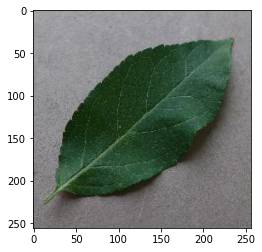

In [30]:
# healthy apple leaf 
img_path = '/content/drive/MyDrive/PlantVillage_Dataset/test/Apple_healthy_leaf/0d01a8a3-9faa-4a1f-afe0-be6bffa42056___RS_HL 6204.JPG'
im, output = outcome_and_image(img_path,model)
im
print(f'Result: {output}')

/content/drive/MyDrive/PlantVillage_Dataset/test/Apple_diseased_leaf/0ca16873-eeac-47e9-9a87-1859950daab7___JR_FrgE.S 2835.JPG

Result: The leaf is a diseased Apple leaf.


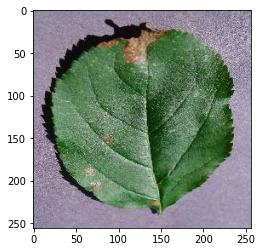

In [32]:
# diseased apple leaf 
img_path = '/content/drive/MyDrive/PlantVillage_Dataset/test/Apple_diseased_leaf/0ca16873-eeac-47e9-9a87-1859950daab7___JR_FrgE.S 2835.JPG'
im, output = outcome_and_image(img_path,model)
im
print(f'Result: {output}')

/content/drive/MyDrive/PlantVillage_Dataset/test/Corn_diseased_leaf/4ef8e489-cafb-4d59-9fc9-00f8087f0cac___RS_NLB 4172.JPG

Result: The leaf is a diseased Corn leaf.


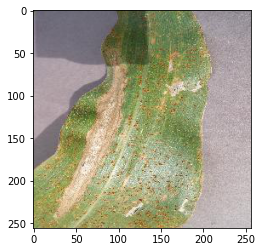

In [36]:
# diseased corn leaf 
img_path = '/content/drive/MyDrive/PlantVillage_Dataset/test/Corn_diseased_leaf/4ef8e489-cafb-4d59-9fc9-00f8087f0cac___RS_NLB 4172.JPG'
im, output = outcome_and_image(img_path,model)
im
print(f'Result: {output}')

/content/drive/MyDrive/PlantVillage_Dataset/test/Corn_healthy_leaf/19c7ec0d-0727-4f08-9ff7-b62936c83a19___R.S_HL 8205 copy 2.jpg

Result: The leaf is a healthy Corn leaf.


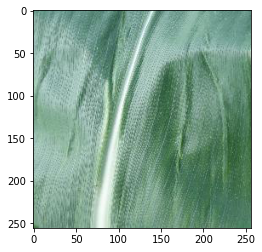

In [38]:
# Healthy corn leaf 
img_path = '/content/drive/MyDrive/PlantVillage_Dataset/test/Corn_healthy_leaf/19c7ec0d-0727-4f08-9ff7-b62936c83a19___R.S_HL 8205 copy 2.jpg'
im, output = outcome_and_image(img_path,model)
im
print(f'Result: {output}')